In [ ]:
import tensorflow as tf
import numpy as np
import random
import scipy.io
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV3Small, MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
## UNCOMMENT ONLY IF UNZIPPING DATASET ###

import zipfile

with zipfile.ZipFile("jpg.zip", "r") as zip_ref:
    zip_ref.extractall("images")


folder_path = "images/jpg"

# Count all files (excluding subdirectories)
file_count = sum(1 for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file)))

print(f"Number of files: {file_count}")


Number of files: 8189


In [ ]:
# Custom Dataset Class Replacement using tf.data
class OxfordFlowersDataset:
    def __init__(self, image_folder, label_file):
        self.image_folder = image_folder
        self.label_file = label_file
        self.image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        self.labels = self._load_labels()

    def _load_labels(self):
        label_data = scipy.io.loadmat(self.label_file)
        image_labels = label_data['labels'].flatten() - 1  # Convert 1-based to 0-based indexing
        return to_categorical(image_labels, num_classes=102)


def load_image(image_path, label, training=True):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))

    # Apply data augmentation ONLY for training
    if training:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
        image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
        image = tf.image.random_hue(image, max_delta=0.05)

    # Normalize correctly for MobileNetV2
    image = tf.cast(image, tf.float32) / 255 # Convert to float

    return image, label




# Load Dataset
dataset = OxfordFlowersDataset("images/jpg", "imagelabels.mat")
image_paths = [os.path.join("images/jpg", f) for f in dataset.image_files]
labels = dataset.labels
train_size = int(0.8 * len(image_paths))

def to_tf_dataset(image_paths, labels, batch_size=128, shuffle=True, training=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: load_image(x, y, training=training), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


# Shuffle dataset first
combined = list(zip(image_paths, labels))
random.shuffle(combined)
image_paths, labels = zip(*combined)

# Convert labels to class indices
label_indices = np.argmax(labels, axis=1)  # Convert one-hot labels back to class indices

# Perform stratified split (ensuring class balance)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=label_indices, random_state=42
)

# Create datasets
train_dataset = to_tf_dataset(train_paths, train_labels, training=True)
val_dataset = to_tf_dataset(val_paths, val_labels, training=False)

In [ ]:
import numpy as np
from pprint import pprint
import collections

train_labels = np.argmax(labels[:train_size], axis=1)
val_labels = np.argmax(labels[train_size:], axis=1)

train_counts = collections.Counter(train_labels)
val_counts = collections.Counter(val_labels)

print("Training set class distribution:", train_counts)
print("Validation set class distribution:", val_counts)

Training set class distribution: Counter({50: 209, 76: 199, 45: 163, 72: 160, 73: 142, 88: 136, 80: 135, 93: 131, 87: 129, 77: 108, 94: 106, 82: 106, 40: 101, 42: 100, 74: 92, 81: 92, 57: 89, 55: 87, 75: 86, 59: 82, 36: 82, 79: 80, 64: 76, 71: 76, 29: 76, 49: 75, 95: 75, 83: 73, 22: 73, 10: 69, 11: 69, 70: 69, 52: 69, 43: 69, 7: 68, 16: 68, 17: 67, 97: 66, 28: 65, 51: 65, 89: 63, 54: 62, 4: 59, 47: 58, 84: 57, 90: 56, 46: 55, 35: 55, 98: 54, 69: 54, 86: 53, 27: 53, 41: 52, 96: 52, 39: 51, 91: 51, 68: 49, 58: 48, 1: 48, 53: 48, 100: 48, 62: 47, 56: 47, 65: 47, 37: 47, 85: 46, 61: 45, 60: 43, 3: 43, 30: 43, 18: 43, 13: 42, 63: 42, 21: 41, 14: 41, 67: 40, 19: 40, 32: 39, 8: 39, 48: 39, 12: 39, 99: 39, 92: 36, 101: 35, 15: 35, 38: 35, 34: 35, 5: 34, 9: 34, 6: 34, 23: 34, 31: 34, 2: 33, 25: 33, 24: 32, 66: 32, 33: 30, 44: 30, 0: 30, 20: 30, 78: 27, 26: 27})
Validation set class distribution: Counter({76: 52, 50: 49, 88: 48, 72: 34, 45: 33, 80: 31, 93: 31, 42: 30, 73: 29, 77: 29, 74: 28, 59:

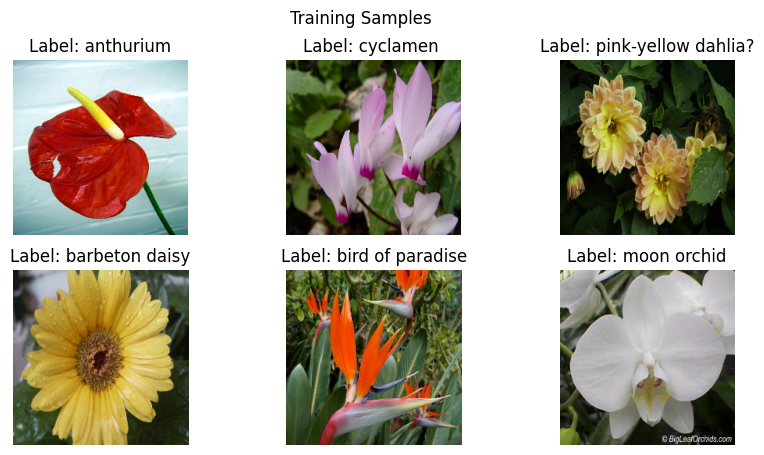

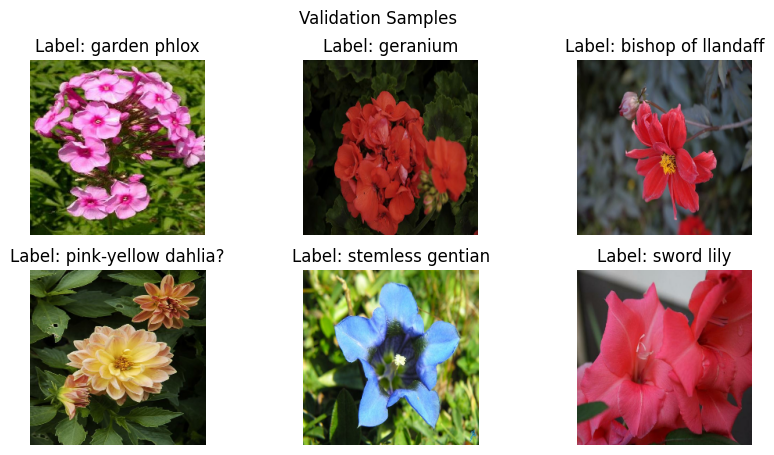

In [ ]:
import matplotlib.pyplot as plt

def show_sample_images(dataset, title):
    plt.figure(figsize=(10, 5))

    # Take one batch, then take individual images
    for i, (image_batch, label_batch) in enumerate(dataset.take(3)):  # Take one batch
        for j in range(6):  # Take first 6 images from the batch
            image = image_batch[j].numpy()
            label = text_labels[label_batch[j].numpy().argmax()]

            plt.subplot(2, 3, j + 1)
            plt.imshow(image)  # No need to convert type
            plt.title(f"Label: {label}")  # Fix label indexing
            plt.axis("off")

    plt.suptitle(title)
    plt.show()

# Display sample training images
show_sample_images(train_dataset, "Training Samples")

# Display sample validation images
show_sample_images(val_dataset, "Validation Samples")


In [ ]:
# Load MobileNetV3 Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(102, activation='softmax')  # 102 flower classes
])

# Compile Model (Feature Extraction)
model.compile(
      optimizer=optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
)

# Train for initial feature extraction
initial_epochs = 10
history = model.fit(train_dataset, validation_data=val_dataset, epochs=initial_epochs, shuffle=True)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 251ms/step - accuracy: 0.1217 - loss: 4.2044 - val_accuracy: 0.6288 - val_loss: 1.8609
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.6061 - loss: 1.7311 - val_accuracy: 0.7869 - val_loss: 1.1302
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.7578 - loss: 1.0955 - val_accuracy: 0.8333 - val_loss: 0.8418
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.8348 - loss: 0.7886 - val_accuracy: 0.8602 - val_loss: 0.7062
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.8550 - loss: 0.6475 - val_accuracy: 0.8687 - val_loss: 0.6259
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.8808 - loss: 0.5495 - val_accuracy: 0.8748 - val_loss: 0.5705
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.8958 - loss: 0.4745 - val_accuracy: 0.8755 - val_loss: 0.5309
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.9045 - loss: 0.4300 - val_accuracy: 0

In [ ]:
# Fine-Tune: Unfreeze Last Few Layers
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # Keep first 30 layers frozen

# Lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
)

# Fine-Tune Model
fine_tune_epochs = 20
history_fine = model.fit(train_dataset, validation_data=val_dataset, epochs=fine_tune_epochs)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 326ms/step - accuracy: 0.5297 - loss: 1.9086 - val_accuracy: 0.8883 - val_loss: 0.4761
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.6737 - loss: 1.2191 - val_accuracy: 0.8852 - val_loss: 0.4816
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.7995 - loss: 0.7663 - val_accuracy: 0.8810 - val_loss: 0.4771
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.8518 - loss: 0.6092 - val_accuracy: 0.8834 - val_loss: 0.4677
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.8755 - loss: 0.5172 - val_accuracy: 0.8797 - val_loss: 0.4584
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.9010 - loss: 0.4450 - val_accuracy: 0.8810 - val_loss: 0.4488
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.9016 - loss: 0.4213 - val_accuracy: 0.8791 - val_loss: 0.4417
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.9064 - loss: 0.3794 - val_accuracy: 0

AttributeError: 'Sequential' object has no attribute 'output_names'

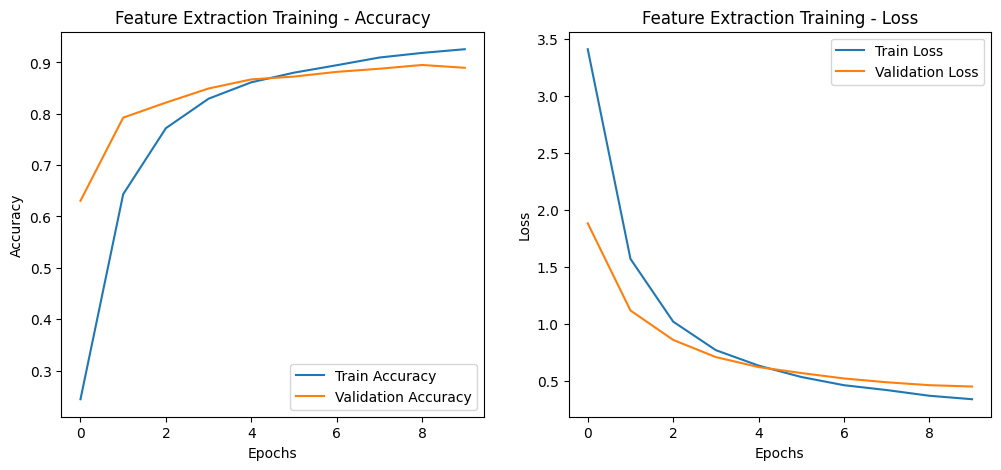

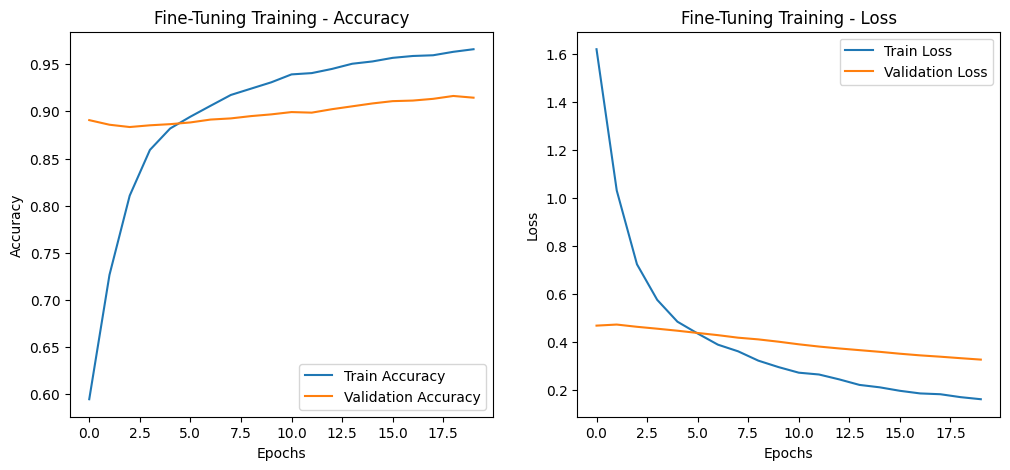

In [ ]:
# Plot Training Metrics
def plot_metrics(history, title="Model Performance"):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

# Display Metrics
plot_metrics(history, title="Feature Extraction Training")
plot_metrics(history_fine, title="Fine-Tuning Training")


In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 130.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 34.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [ ]:
# prompt: delete all files in given list of folders as well as folders themselves

import shutil
import os

def delete_folders(folders_to_delete):
  """Deletes a list of folders and their contents.

  Args:
    folders_to_delete: A list of folder paths to delete.
  """
  for folder in folders_to_delete:
    if os.path.exists(folder):
      try:
          shutil.rmtree(folder)
          print(f"Successfully deleted folder: {folder}")
      except OSError as e:
          print(f"Error deleting folder {folder}: {e}")
    else:
      print(f"Folder not found: {folder}")


# Example usage (replace with your folder paths)
folders_to_delete = ["model"]
delete_folders(folders_to_delete)


Folder not found: flower_classifier_tfjs
Folder not found: flower_classifier_tfjs_1
Folder not found: flower_classifier_tfjs_2
Folder not found: flower_classifier_tfjs_legacy
Folder not found: flower_classifier_tfjs_legacy_1
Folder not found: converted_model
Successfully deleted folder: model
Folder not found: sample_data


In [ ]:
import tensorflowjs as tfjs

tf.saved_model.save(model, "model/tf/mobileV2/")
# tfjs.converters.save_keras_model(model, "flower_classifier_tfjs")

# model.save("flower_classifier_keras_model.h5")
# tfjs.converters.save_keras_model(model, "model/h5/flower_classifier_tfjs_h5")

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model --saved_model_tags=serve --weight_shard_size_bytes=30000000 model/tf/mobileV2/ model/tf2js/mobileV2

2025-03-02 23:09:34.664666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740956974.687058   74528 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740956974.693768   74528 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-03-02 23:09:38.991849: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1740956978.991992   74528 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Test Model

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import scipy.io
import os  # Import os

# Load the SavedModel
loaded_model = tf.saved_model.load("model/tf/mobileV2/")
infer = loaded_model.signatures["serving_default"]

label_data = scipy.io.loadmat("imagelabels.mat")
image_labels = label_data['labels'].flatten() - 1  # 0-based indexing

# Create class_names (assuming sorted filenames match label order)
class_names = [None] * 102
for i in range(len(image_labels)):
    label = image_labels[i]
    if class_names[label] is None:
      class_names[label] = label

text_labels = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]

# --- Image loading and preprocessing ---
img_path = 'waterlily.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make a Prediction
input_name = list(infer.structured_input_signature[1].keys())[0]
predictions = infer(tf.constant(img_array, dtype=tf.float32))
predictions = predictions[list(predictions.keys())[0]]

# --- Get Top-k Predictions and Decode ---
top_k = 10
top_k_indices = np.argsort(predictions[0].numpy())[::-1][:top_k]
top_k_probabilities = tf.gather(predictions[0], top_k_indices).numpy() * 100
top_k_class_names = [text_labels[i] for i in top_k_indices]


# Print the results
print(f"Top {top_k} Predictions:")
for i in range(top_k):
    print(f"  {i+1}. Class: {top_k_class_names[i]}, Probability: {top_k_probabilities[i]:.2f}%")

Top 10 Predictions:
  1. Class: water lily, Probability: 79.09%
  2. Class: great masterwort, Probability: 12.22%
  3. Class: orange dahlia, Probability: 4.13%
  4. Class: tree poppy, Probability: 1.24%
  5. Class: clematis, Probability: 0.46%
  6. Class: gaura, Probability: 0.30%
  7. Class: colt's foot, Probability: 0.22%
  8. Class: lenten rose, Probability: 0.20%
  9. Class: pincushion flower, Probability: 0.18%
  10. Class: bishop of llandaff, Probability: 0.17%
